In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import time
import pickle

import scipy
from scipy.stats import chi2_contingency, mannwhitneyu

import sklearn
from sklearn.model_selection import cross_val_score, GridSearchCV, StratifiedKFold
from sklearn.feature_selection import SelectFromModel,SelectKBest, RFE, f_classif, mutual_info_classif
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import roc_curve, roc_auc_score, auc
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import VotingClassifier
from sklearn import svm

import matplotlib.pyplot as plt
%matplotlib inline

# Formatting

In [2]:
from IPython.display import set_matplotlib_formats
set_matplotlib_formats('pdf', 'png')
plt.rcParams['savefig.dpi'] = 75

plt.rcParams['figure.autolayout'] = False
plt.rcParams['figure.figsize'] = (7, 5)
plt.rcParams['axes.labelsize'] = 18
plt.rcParams['axes.titlesize'] = 20
plt.rcParams['font.size'] = 16
plt.rcParams['lines.linewidth'] = 2.0
plt.rcParams['lines.markersize'] = 8
plt.rcParams['legend.fontsize'] = 14

plt.rcParams['text.usetex'] = False
plt.rcParams['font.family'] = "sans-serif"
plt.rcParams['font.serif'] = "cm"
plt.rcParams['text.latex.preamble'] = "\\usepackage{subdepth} \\usepackage{type1cm}"

# Functions

In [3]:
def t_score(X, y):
    X0 = X[y == 0]
    X1 = X[y == 1]
    
    mu0 = np.mean(X0, axis = 0)
    mu1 = np.mean(X1, axis = 0)
    
    s0 = np.std(X0, axis = 0)
    s1 = np.std(X1, axis = 0)
    
    return np.abs(mu0 - mu1)/(s0 + s1)

def z_score(X):
    mu = np.mean(X, axis = 0)
    s = np.std(X, axis = 0)
    
    return (X - mu)/s

def mwu_score(X, y):
    m, n = X.shape
    
    score = np.zeros(n)
    for i in range(n):
        score[i] = scipy.stats.mannwhitneyu(X[:,i], y)[0]
        
    return score

In [4]:
def cross_val_auc(clf, X, y, n = 10):
    cv = StratifiedKFold(n_splits = n)
    
    aucs = []
    for train, test in cv.split(X, y):
        probas_ = clf.fit(X[train], y[train]).predict_proba(X[test])
        # Compute ROC curve and area the curve
        fpr, tpr, thresholds = roc_curve(y[test], probas_[:, 1])
        roc_auc = auc(fpr, tpr)
        aucs.append(roc_auc)
        
    return aucs

def calc_roc_auc(model, X, y):
    y_score = model.predict_proba(X)[:,1]
    
    fpr, tpr, thresholds = roc_curve(y, y_score)
    roc_auc = auc(fpr, tpr)
    
    return (fpr, tpr, roc_auc)


def plot_roc_curve(fpr, tpr, roc_auc):    
    plt.figure()
    plt.plot(fpr, tpr, color='darkorange', lw=1, label='ROC curve (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], color='navy', lw=1, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('1 - Specificity')
    plt.ylabel('Sensitivity')
    plt.legend(loc="lower right")
    plt.show()

In [5]:
class WeightedVotingClassifier():
    
    def __init__(self, class_score = t_score):
        self.class_score = class_score
                
        # For checking prediction input matches fit shape
        self.m = None
        self.n = None
        
        # Initialize empty before fitting        
        self.mu0 = None
        self.mu1 = None
        self.s0 = None
        self.s1 = None
        self.weights = None
        
        self.f1 = None
        
    def fit(self, X, y):        
        # For checking prediction input matches fit shape
        self.m, self.n = X.shape
        
        X0 = X[y == 0]
        X1 = X[y == 1]
    
        self.mu0 = np.mean(X0, axis = 0)
        self.mu1 = np.mean(X1, axis = 0)
        self.s0 = np.std(X0, axis = 0)
        self.s1 = np.std(X1, axis = 0)
        
        self.weights = self.class_score(X, y)
        if len(self.weights) > 1:
            self.weights = self.weights[0]
        
    def predict(self, X):
        m, n = X.shape
        assert n == self.n, "Input data does not match fit dimensions."
        
        b = (self.mu0 + self.mu1)/2
        votes = np.zeros((m, 2))
        
        for i, xg in enumerate(X):
            d0 = np.abs((xg - self.mu0)/self.s0)
            d1 = np.abs((xg - self.mu1)/self.s1)
            dx = self.weights*np.abs(xg - b)
            
            v0_ind = d0 < d1
            v1_ind = d1 <= d0
            v0 = np.sum(dx[v0_ind])
            v1 = np.sum(dx[v1_ind])
            
            votes[i,0] = v0
            votes[i,1] = v1
          
        self.f0 = votes[:,0]/np.sum(votes, axis = 1)
        self.f1 = votes[:,1]/np.sum(votes, axis = 1)
        preds = np.argmax(votes, axis = 1)
        
        return preds
    
    def predict_proba(self, X):
        self.predict(X) # Update 1 fraction weights
        return np.array([self.f0, self.f1]).T
    
    def get_params(self, deep = False):
        return {'class_score': self.class_score}

# Data Import

In [6]:
b_df = pd.read_csv("data/matrix_bronchial.csv", index_col = 0)
n_df = pd.read_csv("data/matrix_nasal.csv", index_col = 0)

In [7]:
train_df, test_df = sklearn.model_selection.train_test_split(n_df, test_size = 0.1, random_state = 12345)
(train_df.shape[0], test_df.shape[0])

(438, 49)

In [8]:
train_df.head()

,cancer,age,gender,smoker,smoking_quit,mass_size,7892501,7892502,7892503,7892504,...,8180408,8180409,8180410,8180411,8180413,8180414,8180415,8180416,8180417,8180418
geoid,,,,,,,,,,,,,,,,,,,,,
GSM2137165,0,55.449315,1,1,1,1,2.932069,4.070864,2.582677,8.008980,...,8.192856,9.052810,9.450845,5.529531,6.679835,9.514471,6.134313,4.436933,7.415813,8.880868
GSM2137427,0,73.000000,1,0,-1,1,2.579532,3.849077,2.628673,8.703568,...,7.717082,8.997296,9.193001,5.345979,6.894181,9.713782,6.178075,4.421871,7.628149,8.728245
GSM2137179,0,47.000000,0,0,-1,-1,1.763068,3.082161,2.377183,8.833297,...,7.292718,8.405972,9.083116,5.881824,6.836088,9.506780,5.330150,5.065059,7.558969,8.398418
GSM2137413,1,75.454795,1,0,1,-1,2.106988,3.650673,2.549926,8.586780,...,7.737646,8.927904,8.710354,5.387452,6.684257,9.551805,6.382070,4.400418,7.395097,8.358396
GSM2137425,0,42.000000,0,1,1,-1,1.647837,3.439473,3.247707,9.087055,...,7.148801,8.101304,8.216924,7.167894,6.526170,9.262403,5.276680,4.930786,6.754026,7.735028


# Clinical Data Classifier

In [137]:
# Pull Data
X_train = train_df.iloc[:,1:].values
y_train = train_df.iloc[:,0].values
X_test = test_df.iloc[:,1:].values
y_test = test_df.iloc[:,0].values

X_train = StandardScaler().fit_transform(X_train)
X_test = StandardScaler().fit_transform(X_test)

In [138]:
X_train_clinical = X_train[:,0:5]
X_test_clinical = X_test[:,0:5]

## PCA

In [89]:
k = 2

pca = PCA(n_components = k)
pca_fit = pca.fit_transform(X_train_clinical)

v1, v2 = pca.explained_variance_ratio_

print("Explained variance: [{:.3f}, {:.3f}]".format(v1, v2))

Explained variance: [0.361, 0.218]


In [90]:
pca_df = pd.DataFrame(data = pca_fit, columns = ['pc1', 'pc2'], index = train_df.index)
pca_df = pd.concat([train_df["cancer"], pca_df], axis = 1)

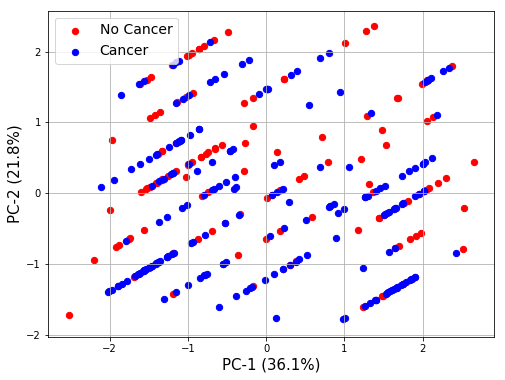

In [91]:
fig = plt.figure(figsize = (8,6))


ax = fig.add_subplot(1,1,1) 
ax.set_xlabel("PC-1 ({:.1f}%)".format(100*v1), fontsize = 15)
ax.set_ylabel("PC-2 ({:.1f}%)".format(100*v2), fontsize = 15)

colors = ['r', 'b']
targets = [0, 1]

for target, color in zip(targets,colors):
    idx = pca_df['cancer'] == target
    ax.scatter(pca_df.loc[idx, 'pc1'], pca_df.loc[idx, 'pc2'], c = color, s = 40)
ax.legend(["No Cancer", "Cancer"])
ax.grid()

## Model Testing

### Weighted Voting

In [640]:
wv_clinical = WeightedVotingClassifier(class_score = t_score)
wv_clinical.fit(X_train_clinical, y_train)

In [641]:
scores = cross_val_score(wv_clinical, X_train_clinical, y_train, cv = 10, scoring = "recall")
accuracy = np.mean(scores)

print("Mean CV Recall = {}".format(accuracy))

Mean CV Accuracy = 0.5676470588235294


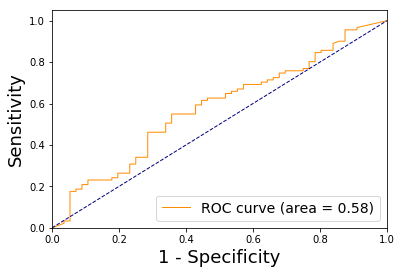

In [642]:
fpr, tpr, roc_auc = calc_roc_auc(wv_clinical, X_test_clinical, y_test)

plot_roc_curve(fpr, tpr, roc_auc)

### Logistic Regression 

In [276]:
lr_clinical = LogisticRegression(solver = "newton-cg")
lr_clinical.fit(X_train_clinical, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='newton-cg',
          tol=0.0001, verbose=0, warm_start=False)

In [279]:
scores = cross_val_score(lr_clinical, X_train_clinical, y_train, cv = 10, scoring = "recall")
accuracy = np.mean(scores)

print("Mean CV Recall = {}".format(accuracy))

Mean CV Accuracy = 0.64349376114082


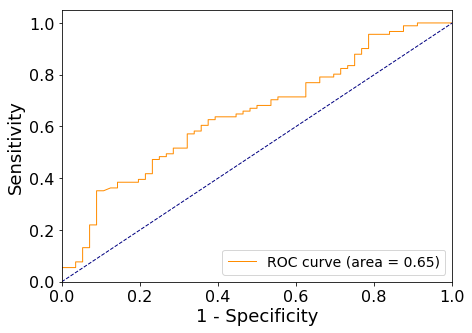

In [292]:
fpr, tpr, roc_auc = calc_roc_auc(lr_clinical, X_test_clinical, y_test)

plot_roc_curve(fpr, tpr, roc_auc)

### SVM

In [283]:
svr_clinical = svm.SVC(C = 2.5, gamma = "auto", kernel = "rbf")
svr_clinical.fit(X_train_clinical, y_train)

SVC(C=2.5, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

In [284]:
scores = cross_val_score(svr_clinical, X_train_clinical, y_train, cv = 10, scoring = "recall")
accuracy = np.mean(scores)

print("Mean CV Recall = {}".format(accuracy))

Mean CV Accuracy = 0.7117850776674306


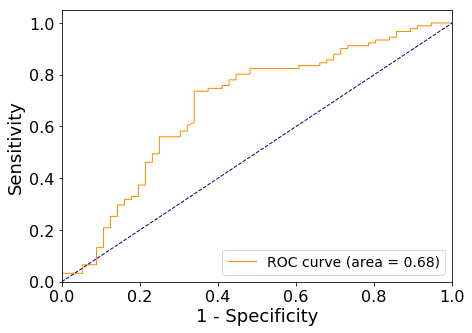

In [293]:
fpr, tpr, roc_auc = calc_roc_auc(svr_clinical, X_test_clinical, y_test)

plot_roc_curve(fpr, tpr, roc_auc)

### Random Forest

In [140]:
rfc_clinical = RandomForestClassifier(random_state = 12345)


parameters = {
    'n_estimators': [50, 100, 500, 1000], 
    'max_depth': [1, 2, 5, 10, None],
    'criterion': ['gini', 'entropy']
}

clf = GridSearchCV(rfc_clinical, parameters, cv = 10, n_jobs = -1)
clf.fit(X_train_clinical, y_train)

clf.best_params_

/Users/sfriedowitz/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'criterion': 'gini', 'max_depth': 5, 'n_estimators': 1000}

In [144]:
rfc_clinical = RandomForestClassifier(n_estimators = 1000,
                             max_depth = 5, 
                             criterion="gini",
                             random_state = 12345)

rfc_clinical.fit(X_train_clinical, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=5, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=1000, n_jobs=None,
            oob_score=False, random_state=12345, verbose=0,
            warm_start=False)

In [145]:
scores = cross_val_score(rfc_clinical, X_train_clinical, y_train, cv = 10, scoring = "recall")
accuracy = np.mean(scores)

print("Mean CV Recall = {}".format(accuracy))

Mean CV Recall = 0.8219047619047618


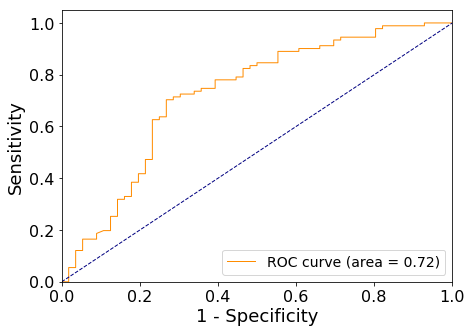

In [146]:
fpr, tpr, roc_auc = calc_roc_auc(rfc_clinical, X_test_clinical, y_test)

plot_roc_curve(fpr, tpr, roc_auc)

# Feature and Model Selection

In [151]:
# Pull Data
X_train = train_df.iloc[:,1:].values
y_train = train_df.iloc[:,0].values
X_test = test_df.iloc[:,1:].values
y_test = test_df.iloc[:,0].values

X_train = StandardScaler().fit_transform(X_train)
X_test = StandardScaler().fit_transform(X_test)

In [152]:
X_train_clinical = X_train[:,0:5]
X_test_clinical = X_test[:,0:5]

X_train_rna = X_train[:,5:]
X_test_rna = X_test[:,5:]

## Weighted Voting Classifier

In [481]:
max_nf = 5000
max_cv = 0
max_k = 0

step = 250
k_vals = np.arange(step, max_nf + step, step)

cv_score = np.zeros(k_vals.shape[0])
cv_std = np.zeros(k_vals.shape[0])
test_score = np.zeros(k_vals.shape[0])

for i, k in enumerate(k_vals):
    
    selector = SelectKBest(t_score, k = k)
    selector.fit(X_train, y_train)
    
    X_train_sel = selector.transform(X_train)
    X_test_sel = selector.transform(X_test)
      
    lr = WeightedVotingClassifier()
    scores = cross_val_score(lr, X_train_sel, y_train, cv = 10, scoring = "roc_auc")
    cv = np.mean(scores)
    cvs = np.std(scores)
            
    cv_score[i] = cv
    cv_std[i] = cvs
    
    lr.fit(X_train_sel, y_train)
    y_score =  lr.predict_proba(X_test_sel)[:,1]
    ts = roc_auc_score(y_test, y_score)
    test_score[i] = ts
    
    if cv > max_cv:
        max_cv = cv
        max_k = k
        print("k = {}, Mean CV Score = {}".format(max_k, max_cv))

k = 250, Mean CV Score = 0.6683843468440329


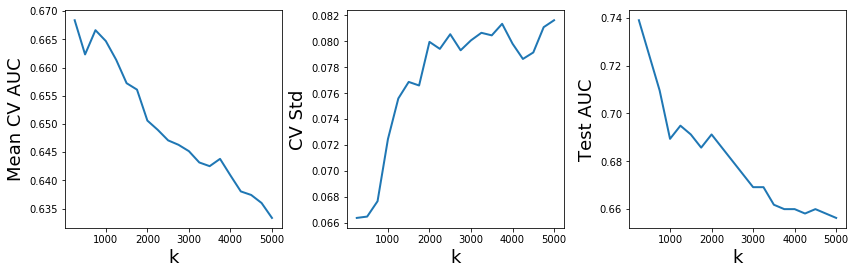

In [482]:
fig, ax = plt.subplots(1, 3, figsize=(14,4)) 
plt.subplots_adjust(wspace = 0.3)

ax1, ax2, ax3 = ax

ax1.plot(k_vals, cv_score)
ax1.set_xlabel("k")
ax1.set_ylabel("Mean CV AUC")

ax2.plot(k_vals, cv_std)
ax2.set_xlabel("k")
ax2.set_ylabel("CV Std")

ax3.plot(k_vals, test_score)
ax3.set_xlabel("k")
ax3.set_ylabel("Test AUC")

plt.show()

## Logistic Regression

### T-Score

In [278]:
max_nf = 5000
max_cv = 0
max_k = 0

step = 250
k_vals = np.arange(step, max_nf + step, step)

cv_score = np.zeros(k_vals.shape[0])
cv_std = np.zeros(k_vals.shape[0])
test_score = np.zeros(k_vals.shape[0])

for i, k in enumerate(k_vals):
    
    selector = SelectKBest(t_score, k = k)
    selector.fit(X_train, y_train)
    
    X_train_sel = selector.transform(X_train)
    X_test_sel = selector.transform(X_test)
      
    lr = LogisticRegression(solver = "newton-cg")
    scores = cross_val_score(lr, X_train_sel, y_train, cv = 10, scoring = "roc_auc")
    cv = np.mean(scores)
    cvs = np.std(scores)
            
    cv_score[i] = cv
    cv_std[i] = cvs
    
    lr.fit(X_train_sel, y_train)
    y_score =  lr.predict_proba(X_test_sel)[:,1]
    ts = roc_auc_score(y_test, y_score)
    test_score[i] = ts
    
    if cv > max_cv:
        max_cv = cv
        max_k = k
        print("k = {}, Mean CV Score = {}".format(max_k, max_cv))

k = 250, Mean CV Score = 0.6905266000037242
k = 500, Mean CV Score = 0.7547818557622479
k = 750, Mean CV Score = 0.807933448783122
k = 1000, Mean CV Score = 0.8330391225816063
k = 1500, Mean CV Score = 0.8334115412546785
k = 2250, Mean CV Score = 0.8437861944397893
k = 2750, Mean CV Score = 0.8488725024672737


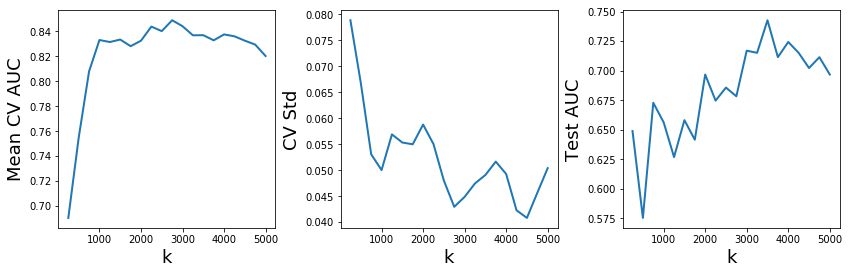

In [279]:
fig, ax = plt.subplots(1, 3, figsize=(14,4)) 
plt.subplots_adjust(wspace = 0.3)

ax1, ax2, ax3 = ax

ax1.plot(k_vals, cv_score)
ax1.set_xlabel("k")
ax1.set_ylabel("Mean CV AUC")

ax2.plot(k_vals, cv_std)
ax2.set_xlabel("k")
ax2.set_ylabel("CV Std")

ax3.plot(k_vals, test_score)
ax3.set_xlabel("k")
ax3.set_ylabel("Test AUC")

plt.show()

### F-Value

In [163]:
max_nf = 5000
max_cv = 0
max_k = 0

step = 250
k_vals = np.arange(step, max_nf + step, step)

cv_score = np.zeros(k_vals.shape[0])
cv_std = np.zeros(k_vals.shape[0])
test_score = np.zeros(k_vals.shape[0])

for i, k in enumerate(k_vals):
    
    selector = SelectKBest(f_classif, k = k)
    selector.fit(X_train, y_train)
    
    X_train_sel = selector.transform(X_train)
    X_test_sel = selector.transform(X_test)
      
    lr = LogisticRegression(solver = "newton-cg")
    scores = cross_val_score(lr, X_train_sel, y_train, cv = 10, scoring = "roc_auc")
    cv = np.mean(scores)
    cvs = np.std(scores)
            
    cv_score[i] = cv
    cv_std[i] = cvs
    
    lr.fit(X_train_sel, y_train)
    y_score =  lr.predict_proba(X_test_sel)[:,1]
    ts = roc_auc_score(y_test, y_score)
    test_score[i] = ts
    
    if cv > max_cv:
        max_cv = cv
        max_k = k
        print("k = {}, Mean CV Score = {}".format(max_k, max_cv))

k = 250, Mean CV Score = 0.6681377204253021
k = 500, Mean CV Score = 0.7488771577006872
k = 750, Mean CV Score = 0.8185268979386627
k = 1000, Mean CV Score = 0.8357829171554663
k = 1500, Mean CV Score = 0.8405796696646369
k = 2750, Mean CV Score = 0.849254231607173


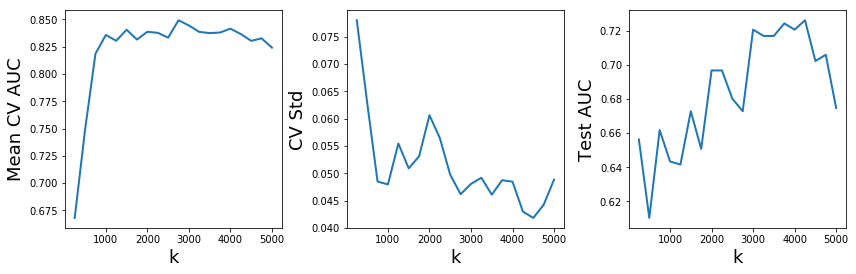

In [164]:
fig, ax = plt.subplots(1, 3, figsize=(14,4)) 
plt.subplots_adjust(wspace = 0.3)

ax1, ax2, ax3 = ax

ax1.plot(k_vals, cv_score)
ax1.set_xlabel("k")
ax1.set_ylabel("Mean CV AUC")

ax2.plot(k_vals, cv_std)
ax2.set_xlabel("k")
ax2.set_ylabel("CV Std")

ax3.plot(k_vals, test_score)
ax3.set_xlabel("k")
ax3.set_ylabel("Test AUC")

plt.show()

### Tree-Based

In [165]:
max_nf = 5000
max_cv = 0
max_k = 0

step = 250
k_vals = np.arange(step, max_nf + step, step)

cv_score = np.zeros(k_vals.shape[0])
cv_std = np.zeros(k_vals.shape[0])
test_score = np.zeros(k_vals.shape[0])

model = ExtraTreesClassifier(n_estimators = 100, random_state = 12345)
model.fit(X_train_rna, y_train)

for i, k in enumerate(k_vals):
    
    selector = SelectFromModel(model, prefit = True, max_features = k)

    X_train_sel = selector.transform(X_train_rna)
    X_test_sel = selector.transform(X_test_rna)

    lr = LogisticRegression(solver = "newton-cg")
    scores = cross_val_score(lr, X_train_sel, y_train, cv = 10, scoring = "roc_auc")
    cv = np.mean(scores)
    cvs = np.std(scores)
            
    cv_score[i] = cv
    cv_std[i] = cvs
    
    lr.fit(X_train_sel, y_train)
    y_score =  lr.predict_proba(X_test_sel)[:,1]
    ts = roc_auc_score(y_test, y_score)
    test_score[i] = ts
    
    if cv > max_cv:
        max_cv = cv
        max_k = k
        print("k = {}, Mean CV Score = {}".format(max_k, max_cv))

k = 250, Mean CV Score = 0.6428458372902817
k = 500, Mean CV Score = 0.6476053479321453
k = 750, Mean CV Score = 0.6818604174813325
k = 1000, Mean CV Score = 0.7283550267210398


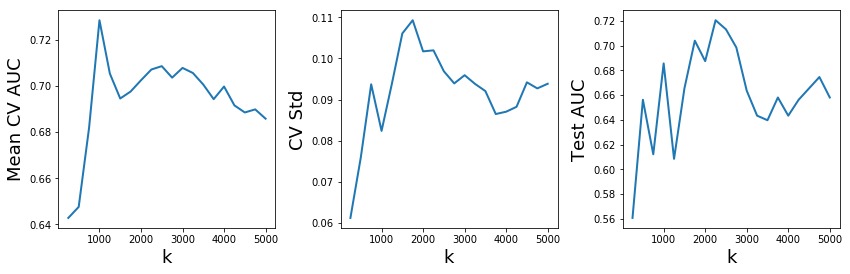

In [166]:
fig, ax = plt.subplots(1, 3, figsize=(14,4)) 
plt.subplots_adjust(wspace = 0.3)

ax1, ax2, ax3 = ax

ax1.plot(k_vals, cv_score)
ax1.set_xlabel("k")
ax1.set_ylabel("Mean CV AUC")

ax2.plot(k_vals, cv_std)
ax2.set_xlabel("k")
ax2.set_ylabel("CV Std")

ax3.plot(k_vals, test_score)
ax3.set_xlabel("k")
ax3.set_ylabel("Test AUC")

plt.show()

## SVM

### T-Score

In [280]:
max_nf = 5000
max_cv = 0
max_k = 0

step = 250
k_vals = np.arange(step, max_nf + step, step)

cv_score = np.zeros(k_vals.shape[0])
cv_std = np.zeros(k_vals.shape[0])
test_score = np.zeros(k_vals.shape[0])
    
for i, k in enumerate(k_vals):
    
    selector = SelectKBest(t_score, k = k)
    selector.fit(X_train, y_train)
    
    X_train_sel = selector.transform(X_train)
    X_test_sel = selector.transform(X_test)
      
    svr = svm.SVC(gamma = "auto", kernel = "rbf", probability = True)
    scores = cross_val_score(svr, X_train_sel, y_train, cv = 10, scoring = "roc_auc")
    cv = np.mean(scores)
    cvs = np.std(scores)
            
    cv_score[i] = cv
    cv_std[i] = cvs
    
    svr.fit(X_train_sel, y_train)
    y_score =  svr.predict_proba(X_test_sel)[:,1]
    ts = roc_auc_score(y_test, y_score)
    test_score[i] = ts
    
    if cv > max_cv:
        max_cv = cv
        max_k = k
        print("k = {}, Mean CV Score = {}".format(max_k, max_cv))

k = 250, Mean CV Score = 0.7069316425525576
k = 500, Mean CV Score = 0.7125747164962851


KeyboardInterrupt: 

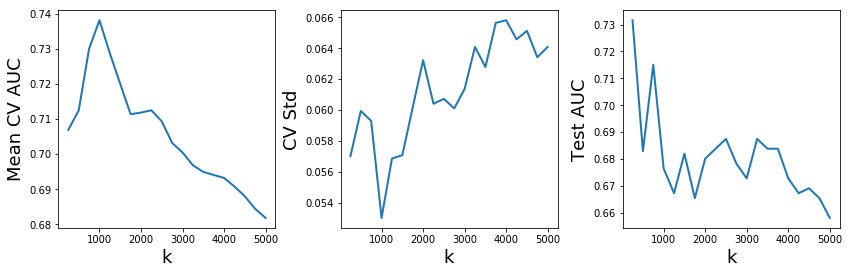

In [200]:
fig, ax = plt.subplots(1, 3, figsize=(14,4)) 
plt.subplots_adjust(wspace = 0.3)

ax1, ax2, ax3 = ax

ax1.plot(k_vals, cv_score)
ax1.set_xlabel("k")
ax1.set_ylabel("Mean CV AUC")

ax2.plot(k_vals, cv_std)
ax2.set_xlabel("k")
ax2.set_ylabel("CV Std")

ax3.plot(k_vals, test_score)
ax3.set_xlabel("k")
ax3.set_ylabel("Test AUC")

plt.show()

### F-Value

In [171]:
max_nf = 3000
max_cv = 0
max_k = 0

step = 500
k_vals = np.arange(step, max_nf + step, step)

cv_score = np.zeros(k_vals.shape[0])
cv_std = np.zeros(k_vals.shape[0])
test_score = np.zeros(k_vals.shape[0])

for i, k in enumerate(k_vals):
    
    selector = SelectKBest(f_classif, k = k)
    selector.fit(X_train, y_train)
    
    X_train_sel = selector.transform(X_train)
    X_test_sel = selector.transform(X_test)
      
    svr = svm.SVC(C = 3, gamma = "auto", kernel = "rbf", probability = True)
    scores = cross_val_score(svr, X_train_sel, y_train, cv = 10, scoring = "roc_auc")
    cv = np.mean(scores)
    cvs = np.std(scores)
            
    cv_score[i] = cv
    cv_std[i] = cvs
    
    svr.fit(X_train_sel, y_train)
    y_score =  svr.predict_proba(X_test_sel)[:,1]
    ts = roc_auc_score(y_test, y_score)
    test_score[i] = ts
    
    if cv > max_cv:
        max_cv = cv
        max_k = k
        print("k = {}, Mean CV Score = {}".format(max_k, max_cv))

k = 500, Mean CV Score = 0.7457795653874084
k = 1000, Mean CV Score = 0.7895424836601308


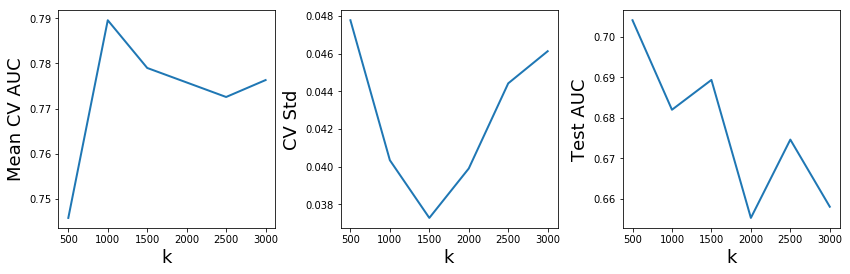

In [172]:
fig, ax = plt.subplots(1, 3, figsize=(14,4)) 
plt.subplots_adjust(wspace = 0.3)

ax1, ax2, ax3 = ax

ax1.plot(k_vals, cv_score)
ax1.set_xlabel("k")
ax1.set_ylabel("Mean CV AUC")

ax2.plot(k_vals, cv_std)
ax2.set_xlabel("k")
ax2.set_ylabel("CV Std")

ax3.plot(k_vals, test_score)
ax3.set_xlabel("k")
ax3.set_ylabel("Test AUC")

plt.show()

### Tree Based

In [173]:
max_nf = 3000
max_cv = 0
max_k = 0

step = 500
k_vals = np.arange(step, max_nf + step, step)

cv_score = np.zeros(k_vals.shape[0])
cv_std = np.zeros(k_vals.shape[0])
test_score = np.zeros(k_vals.shape[0])

model = ExtraTreesClassifier(n_estimators = 100, random_state = 12345)
model.fit(X_train_rna, y_train)

for i, k in enumerate(k_vals):
    
    selector = SelectFromModel(model, prefit = True, max_features = k)

    X_train_sel = selector.transform(X_train_rna)
    X_test_sel = selector.transform(X_test_rna)

    svr = svm.SVC(C = 3, gamma = "auto", kernel = "rbf", probability = True)
    scores = cross_val_score(svr, X_train_sel, y_train, cv = 10, scoring = "roc_auc")
    cv = np.mean(scores)
    cvs = np.std(scores)
            
    cv_score[i] = cv
    cv_std[i] = cvs
    
    svr.fit(X_train_sel, y_train)
    y_score =  svr.predict_proba(X_test_sel)[:,1]
    ts = roc_auc_score(y_test, y_score)
    test_score[i] = ts
    
    if cv > max_cv:
        max_cv = cv
        max_k = k
        print("k = {}, Mean CV Score = {}".format(max_k, max_cv))

k = 500, Mean CV Score = 0.7092522764091391
k = 1000, Mean CV Score = 0.7279965737482078


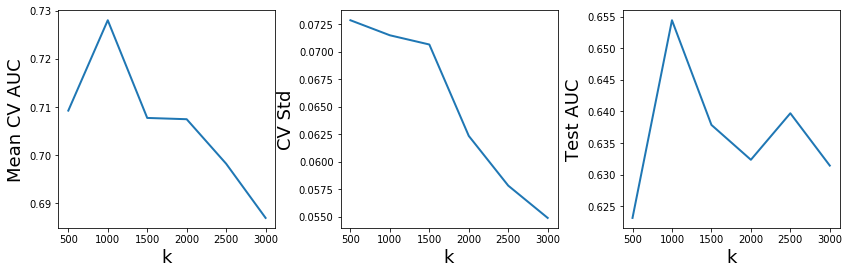

In [175]:
fig, ax = plt.subplots(1, 3, figsize=(14,4)) 
plt.subplots_adjust(wspace = 0.3)

ax1, ax2, ax3 = ax

ax1.plot(k_vals, cv_score)
ax1.set_xlabel("k")
ax1.set_ylabel("Mean CV AUC")

ax2.plot(k_vals, cv_std)
ax2.set_xlabel("k")
ax2.set_ylabel("CV Std")

ax3.plot(k_vals, test_score)
ax3.set_xlabel("k")
ax3.set_ylabel("Test AUC")

plt.show()

## Random Forest

### T-Score

In [130]:
max_nf = 2000
max_cv = 0
max_k = 0

step = 250
k_vals = np.arange(step, max_nf + step, step)

cv_score = np.zeros(k_vals.shape[0])
cv_std = np.zeros(k_vals.shape[0])
test_score = np.zeros(k_vals.shape[0])

for i, k in enumerate(k_vals):
    
    selector = SelectKBest(t_score, k = k)
    selector.fit(X_train, y_train)
    
    X_train_sel = selector.transform(X_train)
    X_test_sel = selector.transform(X_test)
     
    rfc = RandomForestClassifier(n_estimators = 100, random_state = 12345, n_jobs = -1)
    scores = cross_val_score(rfc, X_train_sel, y_train, cv = 10, scoring = "roc_auc")
    cv = np.mean(scores)
    cvs = np.std(scores)
            
    cv_score[i] = cv
    cv_std[i] = cvs
    
    rfc.fit(X_train_sel, y_train)
    y_score =  rfc.predict_proba(X_test_sel)[:,1]
    ts = roc_auc_score(y_test, y_score)
    test_score[i] = ts
    
    if cv > max_cv:
        max_cv = cv
        max_k = k
        print("k = {}, Mean CV Score = {}".format(max_k, max_cv))

k = 250, Mean CV Score = 0.6698778466752323
k = 500, Mean CV Score = 0.6833510232203043


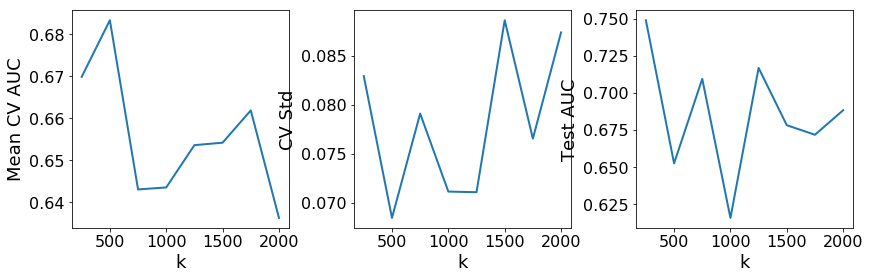

In [131]:
fig, ax = plt.subplots(1, 3, figsize=(14,4)) 
plt.subplots_adjust(wspace = 0.3)

ax1, ax2, ax3 = ax

ax1.plot(k_vals, cv_score)
ax1.set_xlabel("k")
ax1.set_ylabel("Mean CV AUC")

ax2.plot(k_vals, cv_std)
ax2.set_xlabel("k")
ax2.set_ylabel("CV Std")

ax3.plot(k_vals, test_score)
ax3.set_xlabel("k")
ax3.set_ylabel("Test AUC")

plt.show()

### F-Value

In [186]:
max_nf = 5000
max_cv = 0
max_k = 0

step = 250
k_vals = np.arange(step, max_nf + step, step)

cv_score = np.zeros(k_vals.shape[0])
cv_std = np.zeros(k_vals.shape[0])
test_score = np.zeros(k_vals.shape[0])

for i, k in enumerate(k_vals):
    
    selector = SelectKBest(f_classif, k = k)
    selector.fit(X_train, y_train)
    
    X_train_sel = selector.transform(X_train)
    X_test_sel = selector.transform(X_test)
      
    rfc = RandomForestClassifier(n_estimators = 50, random_state = 12345, max_features = 0.1)
    scores = cross_val_score(rfc, X_train_sel, y_train, cv = 10, scoring = "roc_auc")
    cv = np.mean(scores)
    cvs = np.std(scores)
            
    cv_score[i] = cv
    cv_std[i] = cvs
    
    rfc.fit(X_train_sel, y_train)
    y_score =  rfc.predict_proba(X_test_sel)[:,1]
    ts = roc_auc_score(y_test, y_score)
    test_score[i] = ts
    
    if cv > max_cv:
        max_cv = cv
        max_k = k
        print("k = {}, Mean CV Score = {}".format(max_k, max_cv))

k = 250, Mean CV Score = 0.6649533440210466
k = 1750, Mean CV Score = 0.6881836759861177


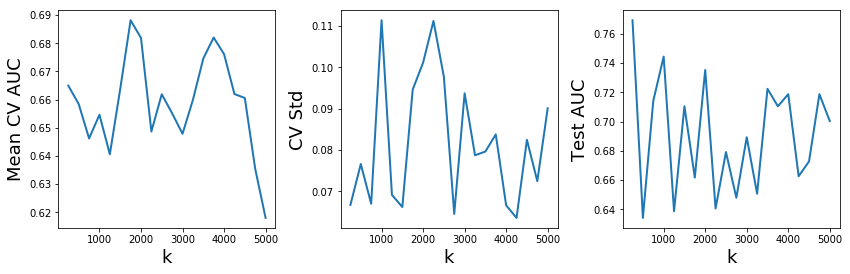

In [187]:
fig, ax = plt.subplots(1, 3, figsize=(14,4)) 
plt.subplots_adjust(wspace = 0.3)

ax1, ax2, ax3 = ax

ax1.plot(k_vals, cv_score)
ax1.set_xlabel("k")
ax1.set_ylabel("Mean CV AUC")

ax2.plot(k_vals, cv_std)
ax2.set_xlabel("k")
ax2.set_ylabel("CV Std")

ax3.plot(k_vals, test_score)
ax3.set_xlabel("k")
ax3.set_ylabel("Test AUC")

plt.show()

### Tree Based

In [191]:
max_nf = 5000
max_cv = 0
max_k = 0

step = 1000
k_vals = np.arange(step, max_nf + step, step)

cv_score = np.zeros(k_vals.shape[0])
cv_std = np.zeros(k_vals.shape[0])
test_score = np.zeros(k_vals.shape[0])

model = ExtraTreesClassifier(n_estimators = 100, random_state = 12345)
model.fit(X_train, y_train)

for i, k in enumerate(k_vals):
    
    selector = SelectFromModel(model, prefit = True, max_features = k)

    X_train_sel = selector.transform(X_train)
    X_test_sel = selector.transform(X_test)

    rfc = RandomForestClassifier(n_estimators = 100, random_state = 12345, max_features = 0.5)
    scores = cross_val_score(rfc, X_train_sel, y_train, cv = 10, scoring = "roc_auc")
    cv = np.mean(scores)
    cvs = np.std(scores)
            
    cv_score[i] = cv
    cv_std[i] = cvs
    
    rfc.fit(X_train_sel, y_train)
    y_score =  rfc.predict_proba(X_test_sel)[:,1]
    ts = roc_auc_score(y_test, y_score)
    test_score[i] = ts
    
    if cv > max_cv:
        max_cv = cv
        max_k = k
        print("k = {}, Mean CV Score = {}".format(max_k, max_cv))

k = 1000, Mean CV Score = 0.7477169987491852


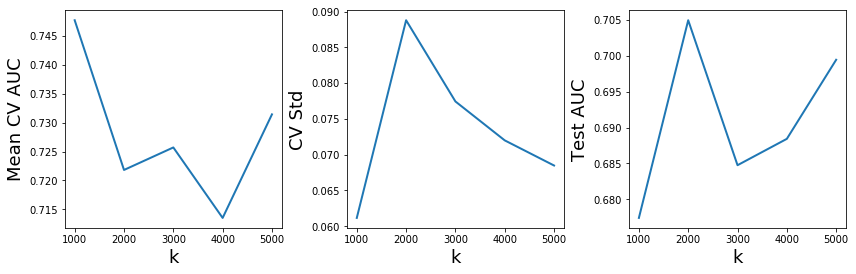

In [192]:
fig, ax = plt.subplots(1, 3, figsize=(14,4)) 
plt.subplots_adjust(wspace = 0.3)

ax1, ax2, ax3 = ax

ax1.plot(k_vals, cv_score)
ax1.set_xlabel("k")
ax1.set_ylabel("Mean CV AUC")

ax2.plot(k_vals, cv_std)
ax2.set_xlabel("k")
ax2.set_ylabel("CV Std")

ax3.plot(k_vals, test_score)
ax3.set_xlabel("k")
ax3.set_ylabel("Test AUC")

plt.show()

## Plots

In [258]:
max_nf = 5000
step = 250
k_vals = np.arange(step, max_nf + step, step)

lr_tree_scores = np.array([
    0.6905266 , 0.75478186, 0.80793345, 0.83303912, 0.83141724,
    0.83341154, 0.82810178, 0.83248981, 0.84378619, 0.84014953,
    0.8488725 , 0.8440953 , 0.83681265, 0.83690297, 0.83279798,
    0.83750908, 0.83599985, 0.83251122, 0.82937359, 0.8202214 
])

svm_tree_scores = np.array([
    0.70693164, 0.71246578, 0.73006489, 0.73821388, 0.728774  ,
    0.72003612, 0.71140905, 0.711862  , 0.7125128 , 0.70937098,
    0.7031879 , 0.70046971, 0.69682141, 0.6949258 , 0.69406551,
    0.69320988, 0.69075471, 0.68797833, 0.68438449, 0.68179711
])

rfc_tree_scores = np.array([
    0.74343798, 0.74218666, 0.73263226, 0.72990056, 0.73913189,
    0.74593598, 0.72600972, 0.73309685, 0.73880416, 0.73491984,
    0.72758133, 0.74914809, 0.7400918 , 0.73639461, 0.73646537,
    0.74038043, 0.72268309, 0.73620934, 0.74048098, 0.73208108
])

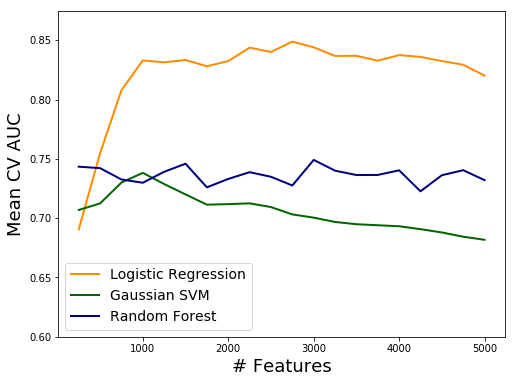

In [259]:
plt.figure(figsize = (8, 6))

plt.plot(k_vals, lr_tree_scores, c = "darkorange", label = "Logistic Regression")
plt.plot(k_vals, svm_tree_scores, c = "darkgreen", label = "Gaussian SVM")
plt.plot(k_vals, rfc_tree_scores, c = "navy", label = "Random Forest")

plt.ylim([0.6, 0.875])

plt.xlabel("# Features")
plt.ylabel("Mean CV AUC")
plt.legend(loc="lower left")

plt.savefig("images/recall_features_model.png", dpi = 300)
plt.show()

# Model Tuning

In this section, we optimize hyperparameters for both an SVM and RF classifier, using the optimal feature subset determined from the above analysis.

In [9]:
# Pull Data
X_train = train_df.iloc[:,1:].values
y_train = train_df.iloc[:,0].values
X_test = test_df.iloc[:,1:].values
y_test = test_df.iloc[:,0].values

X_train = StandardScaler().fit_transform(X_train)
X_test = StandardScaler().fit_transform(X_test)

In [10]:
X_train_clinical = X_train[:,0:5]
X_test_clinical = X_test[:,0:5]

X_train_rna = X_train[:,5:]
X_test_rna = X_test[:,5:]

Choose 3000 best features from a tree-based classifier to use in the model.

In [201]:
selector = SelectKBest(f_classif, k = 3500)
selector.fit(X_train, y_train)
    
X_train_sel = selector.transform(X_train)
X_test_sel = selector.transform(X_test)

In [202]:
top_features = np.argsort(-selector.scores_)
top_features[:50]

array([    4,  2195, 17462, 32111, 12105, 23059, 28616, 14345, 14416,
       25525, 32051,  7942, 24425, 32042, 32108, 26551,  8370, 30678,
       32112, 32104, 25785, 25781, 28548, 24152,  7336,  7672, 18458,
       13536, 30445, 18376, 12667, 21289,  6450, 32043, 31957, 32008,
       32009, 32109, 21283,  9757, 21599, 32005, 11644,  4207,  5125,
       27509,  9181, 23545, 27650,  7159])

## PCA Reduction

In [203]:
var = 0
k = 5

while var < 0.9:
    
    pca = PCA(n_components = k)
    pca.fit(X_train_sel)
    
    var = np.sum(pca.explained_variance_ratio_)
    
    print("k = {}, Explained variance = {}".format(k, var))
    
    k += 5

k = 5, Explained variance = 0.5010296566590988
k = 10, Explained variance = 0.5795360819935478
k = 15, Explained variance = 0.6212988554890674
k = 20, Explained variance = 0.6481008624203658
k = 25, Explained variance = 0.6689938945067316
k = 30, Explained variance = 0.6860360952487197
k = 35, Explained variance = 0.6998017707212123
k = 40, Explained variance = 0.7116041037749731
k = 45, Explained variance = 0.7212783995284907
k = 50, Explained variance = 0.7308953218425344
k = 55, Explained variance = 0.7394993358723505
k = 60, Explained variance = 0.7474037101935693
k = 65, Explained variance = 0.7549160250603308
k = 70, Explained variance = 0.7622674356183203
k = 75, Explained variance = 0.7692788425997367
k = 80, Explained variance = 0.7758849634223461
k = 85, Explained variance = 0.7822454091543359
k = 90, Explained variance = 0.7884194631276416
k = 95, Explained variance = 0.7946909234931829
k = 100, Explained variance = 0.8004802786241545
k = 105, Explained variance = 0.80618254

In [204]:
k = 215

pca = PCA(n_components = k)
X_train_pca = pca.fit_transform(X_train_sel)
X_test_pca = pca.transform(X_test_sel)

X0_pca = X_train_pca[y_train == 0]
X1_pca = X_train_pca[y_train == 1]

np.sum(pca.explained_variance_ratio_)

0.90351525828676

In [ ]:
fig, axn = plt.subplots(1, 2, sharey=True)
cbar_ax = fig.add_axes([.91, .3, .03, .4])

pca_title = ["No Cancer", "Cancer"]
pca_data = [X0_pca, X1_pca]

for i, ax in enumerate(axn.flat):
    ax.set_title(pca_title[i])
    sns.heatmap(pca_data[i].T, ax=ax,
                cbar= i == 0,
                cbar_ax=None if i else cbar_ax)

fig.tight_layout(rect=[0, 0, .9, 1])

/Users/sfriedowitz/anaconda3/lib/python3.6/site-packages/matplotlib/figure.py:2362: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


## Logistic Regression

In [205]:
lr = LogisticRegression()

parameters = {
    'C': [0.005, 0.0075, 0.01, 0.05]
}

clf = GridSearchCV(lr, parameters, cv = 10, n_jobs = -1, scoring = "roc_auc")
clf.fit(X_train_pca, y_train)

clf.best_params_

/Users/sfriedowitz/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
/Users/sfriedowitz/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


{'C': 0.0075}

In [221]:
lr = LogisticRegression(C = 0.0075, solver = 'newton-cg')
lr.fit(X_train_pca, y_train)

LogisticRegression(C=0.0075, class_weight=None, dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='warn', n_jobs=None, penalty='l2', random_state=None,
          solver='newton-cg', tol=0.0001, verbose=0, warm_start=False)

In [222]:
scores = cross_val_score(lr, X_train_pca, y_train, cv = 10, scoring = "roc_auc")
np.mean(scores)

0.8549457199783997

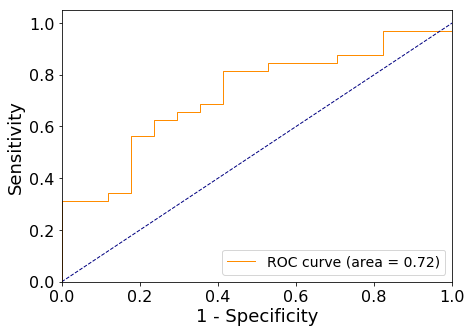

In [223]:
fpr, tpr, roc_auc = calc_roc_auc(lr, X_test_pca, y_test)

plot_roc_curve(fpr, tpr, roc_auc)

In [224]:
y_test_pred = lr.predict(X_test_pca)

sklearn.metrics.confusion_matrix(y_test, y_test_pred)

array([[ 9,  8],
       [ 6, 26]])

In [225]:
sklearn.metrics.recall_score(y_test, y_test_pred)

0.8125

## Random Forest

This takes a very long time to run since of the high dimensional parameter space.

In [329]:
rfc = RandomForestClassifier(random_state = 12345)


parameters = {
    'max_features': [0.25, 0.5, 0.75]
}

clf = GridSearchCV(rfc, parameters, cv = 10, n_jobs = -1, scoring = "roc_auc")
clf.fit(X_train_pca, y_train)

clf.best_params_

/Users/sfriedowitz/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
/Users/sfriedowitz/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:248: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


{'max_features': 0.5}

In [275]:
rfc = RandomForestClassifier(n_estimators = 100,
                             max_features = "sqrt",
                             max_depth = 5,
                             random_state = 12345)

rfc.fit(X_train_pca, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=5, max_features='sqrt', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=None,
            oob_score=False, random_state=12345, verbose=0,
            warm_start=False)

In [107]:
scores = cross_val_score(rfc, X_train_pca, y_train, cv = 5, scoring = "roc_auc")
np.mean(scores)

0.6720142228799277

In [108]:
scores

array([0.64312169, 0.75579515, 0.62680355, 0.57241953, 0.76193119])

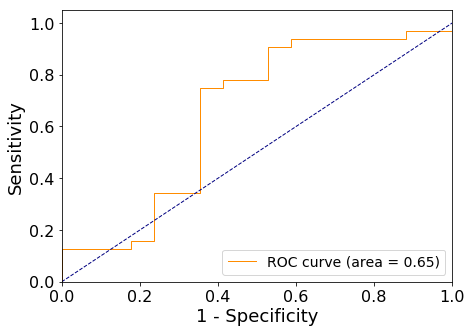

In [276]:
fpr, tpr, roc_auc = calc_roc_auc(rfc, X_test_pca, y_test)

plot_roc_curve(fpr, tpr, roc_auc)

In [277]:
y_test_pred = rfc.predict(X_test_pca)

sklearn.metrics.confusion_matrix(y_test, y_test_pred)

array([[ 0, 17],
       [ 1, 31]])

In [278]:
sklearn.metrics.recall_score(y_test, y_test_pred)

0.96875

# Model Testing

In [12]:
# Pull Data
X_train = train_df.iloc[:,1:].values
y_train = train_df.iloc[:,0].values
X_test = test_df.iloc[:,1:].values
y_test = test_df.iloc[:,0].values

X_train = StandardScaler().fit_transform(X_train)
X_test = StandardScaler().fit_transform(X_test)

In [13]:
X_train_clinical = X_train[:,0:5]
X_test_clinical = X_test[:,0:5]

X_train_rna = X_train[:,5:]
X_test_rna = X_test[:,5:]

In [14]:
top_features = np.array([
    4, 7447,  6477, 25762, 18629,  1289,  2359, 32111,  5276,
    18581, 25294, 21997, 18746,  6339,  8456,  3207, 30676, 28444,
    32005, 17861, 25085, 15338,  3669,  3208, 30336, 19869,  7890,
    20810,  8487, 23322, 29401, 25641, 15667,  5887, 24949, 31269,
    17413, 15548, 22430, 15606, 26469, 16111, 18728, 30298,  7017,
    20278,  9972, 27776, 15941, 30571, 22419, 20385, 24668
])

In [15]:
X_train_sel = X_train[:, top_features]
X_test_sel = X_test[:, top_features]

In [16]:
pca = PCA(n_components = 33)
X_train_pca = pca.fit_transform(X_train_sel)
X_test_pca = pca.transform(X_test_sel)

Clinical Model:

In [17]:
rfc_clinical = RandomForestClassifier(n_estimators = 1000,
                             max_depth = 5, 
                             criterion="gini",
                             random_state = 12345)

rfc_clinical.fit(X_train_clinical, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=5, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=1000, n_jobs=None,
            oob_score=False, random_state=12345, verbose=0,
            warm_start=False)

Full Model:

In [18]:
rfc_full = RandomForestClassifier(n_estimators = 500,
                             max_depth = None, 
                             max_features = 0.2,
                             criterion="gini",
                             random_state = 12345)

rfc_full.fit(X_train_pca, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features=0.2, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=500, n_jobs=None,
            oob_score=False, random_state=12345, verbose=0,
            warm_start=False)

## Testing

In [19]:
y_clinical_pred = rfc_clinical.predict(X_test_clinical)
y_full_pred = rfc_full.predict(X_test_pca)

In [20]:
recall_c = cross_val_score(rfc_clinical, X_train_clinical, y_train, cv = 10, scoring = "recall")
recall_f = cross_val_score(rfc_full, X_train_pca, y_train, cv = 10, scoring = "recall")

recall_c = np.mean(recall_c)
recall_f = np.mean(recall_f)

print("Mean Clincal Recall = {}\nMean Full Recall = {}".format(recall_c, recall_f))

Mean Clincal Recall = 0.8219047619047618
Mean Full Recall = 0.8604761904761904


In [21]:
accuracy_c = sklearn.metrics.accuracy_score(y_test, y_clinical_pred)
accuracy_f = sklearn.metrics.accuracy_score(y_test, y_full_pred)

print("Clinical Accuracy = {}\nFull Accuracy = {}".format(accuracy_c, accuracy_f))

Clinical Accuracy = 0.7006802721088435
Full Accuracy = 0.6666666666666666


In [23]:
precision_c = sklearn.metrics.precision_score(y_test, y_clinical_pred)
precision_f = sklearn.metrics.precision_score(y_test, y_full_pred)

print("Clinical Precision = {}\nFull Precision = {}".format(precision_c, precision_f))

Clinical Precision = 0.7422680412371134
Full Precision = 0.675


In [22]:
recall_c = sklearn.metrics.recall_score(y_test, y_clinical_pred)
recall_f = sklearn.metrics.recall_score(y_test, y_full_pred)

print("Clinical Recall = {}\nFull Recall = {}".format(recall_c, recall_f))

Clinical Recall = 0.7912087912087912
Full Recall = 0.8901098901098901


In [24]:
fpr_c, tpr_c, roc_auc_c = calc_roc_auc(rfc_clinical, X_test_clinical, y_test)
fpr_f, tpr_f, roc_auc_f = calc_roc_auc(rfc_full, X_test_pca, y_test)

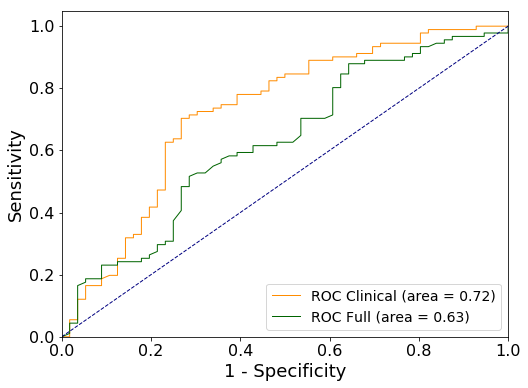

In [25]:
plt.figure(figsize = (8,6))
plt.plot(fpr_c, tpr_c, color='darkorange', lw=1, label='ROC Clinical (area = %0.2f)' % roc_auc_c)
plt.plot(fpr_f, tpr_f, color='darkgreen', lw=1, label='ROC Full (area = %0.2f)' % roc_auc_f)
plt.plot([0, 1], [0, 1], color='navy', lw=1, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])


plt.xlabel('1 - Specificity')
plt.ylabel('Sensitivity')
plt.legend(loc="lower right")

plt.savefig("images/roc_clinical_full.png", dpi = 300)
plt.show()

# Gene Names for Top Genes

In [53]:
top_features = np.array([
    4, 7447,  6477, 25762, 18629,  1289,  2359, 32111,  5276,
    18581, 25294, 21997, 18746,  6339,  8456,  3207, 30676, 28444,
    32005, 17861, 25085, 15338,  3669,  3208, 30336, 19869,  7890,
    20810,  8487, 23322, 29401, 25641, 15667,  5887, 24949, 31269,
    17413, 15548, 22430, 15606, 26469, 16111, 18728, 30298,  7017,
    20278,  9972, 27776, 15941, 30571, 22419, 20385, 24668
]) 

tf1 = top_features + 1

Load lookup dictionary (created in parse_data)

In [51]:
f = open('data/gene_dict.pkl','rb')
gene_dict = pickle.load(f)
f.close()

Get the top gene IDs

In [54]:
top_gene_IDs = train_df.iloc[0:1,tf1].columns
top_gene_IDs

Index(['mass_size', '7931899', '7921738', '8117301', '8045343', '7893812',
       '7894907', '8180078', '7909188', '8045028', '8112998', '8080144',
       '8046527', '7920205', '7941749', '7895770', '8166059', '8144226',
       '8179019', '8038292', '8110932', '8012856', '7896248', '7895771',
       '8162514', '8058591', '7936673', '8068057', '7942204', '8094028',
       '8153021', '8116316', '8016257', '7915657', '8109618', '8171449',
       '8033912', '8014974', '8084627', '8015607', '8124413', '8020827',
       '8046340', '8162177', '7927120', '8063000', '7956044', '8137979',
       '8019308', '8165046', '8084397', '8064042', '8106771'],
      dtype='object')

The first feature is clinical data. In the below, missing entries have not been identified as genes for a particular mRNA (i.e. if a gene ID is missing we don't know exactly what it is. Affimetrix updates their database twice a year).

In [55]:
best_feats = [['mass_size', ('N/A')]]
best_feats.append( [[i,gene_dict[i]] for i in top_gene_IDs[1:] if (i in gene_dict)] )
best_feats

[['mass_size', 'N/A'],
 [['7931899', ('IL15RA',)],
  ['7921738', ('USF1',)],
  ['8117301', ('HIST1H2BA',)],
  ['8180078', ('HLA-DMB',)],
  ['7909188', ('IKBKE',)],
  ['8112998', ('LOC645261',)],
  ['8080144', ('PARP3',)],
  ['8046527', ('HOXD12',)],
  ['7920205', ('SPRR2A',)],
  ['7941749', ('SYT12',)],
  ['8166059', ('TLR7',)],
  ['8179019', ('HLA-F',)],
  ['8038292', ('CGB5',)],
  ['8110932', ('SEMA5A',)],
  ['8012856', ('ELAC2',)],
  ['8162514', ('FANCC',)],
  ['8058591', ('ACADL',)],
  ['7936673', ('RGS10',)],
  ['8068057', ('LINC00161',)],
  ['7942204', ('CTTN',)],
  ['8094028', ('AFAP1-AS1',)],
  ['8153021', ('ST3GAL1',)],
  ['8116316', ('MGAT4B',)],
  ['8171449', ('ACE2',)],
  ['8033912', ('DNMT1',)],
  ['8014974', ('TOP2A',)],
  ['8084627', ('IGF2BP2-AS1',)],
  ['8015607', ('STAT3',)],
  ['8124413', ('HIST1H4D',)],
  ['8020827', ('MEP1B',)],
  ['8046340', ('DYNC1I2',)],
  ['7927120', ('RET',)],
  ['8063000', ('WFDC2',)],
  ['8137979', ('ACTB',)],
  ['8019308', ('MAFG',)],
  ['8

Gene Identities (from genecards.org) 

IL15RA - Subunit of inerleukin 15 receptor, receptor enhances cell proliferation and inhibits cellular apoptosis.

USF1 - Upstream Stimulatory Factor I, cellular transcription factor (activates transcription) 

HIST1H2BA - Histone H2b Type t-A, histones are responsible for structure of chromosomes 

HLA-DMB - HLA class II Histocompatability antigen, previously linked to prostrate cancer, observed to be upregulated in caucasian patients (https://www.ncbi.nlm.nih.gov/pmc/articles/PMC3800217/) 

IKBKE - Inhibitor of nuclear factor kappa-B kinase subunit epsilon, reugulates antiviral signaling pathways, overexpressed in breat cancer Hutti et al., 2009 [PubMed 19481526]

LOC645261 - ncRNA (not translated to preotein)

PARP3 - PARP family is required for DNA repair, regulation of aoptosis, and maintaining genomic stability

HOXD12 - Transcription factors (common to mammals)

SPPR2A - Small, proline-containing protein membrane protein

SYT12 - Mediates calcium-dependent secretion across membrane

TLR7 - Toll-like receptor 7, reponsible for pathogen recognition and activation of immune system

HLA-F - HLA class I histocompatibility antigen, function unknown but does different things during immune response

CGB5 - Signals ovaries to synthesize steroids essential for maintenance of pregancy

SEMA5A - Some link to angiogenesis (makign new blood vessels); enhances cell proliferation and inhibits apoptosis.

ELAC2 - Has been linked to prostrate cancer, https://www.nature.com/articles/pcan20106

FANCC - Fanconi Anemia pathway - activates when new DNA is made. Mutations cause disruption of the DNA repair process, which can lead to cell death and/or cancer. (Citation)

ACADL - Acyl-CoA Dehydrogenase, responsible for metabolizing unsaturated fats. 

RGS10 - GTPase activating proteins

LINC00161 - ncRNA, linked to osteosarcoma (bone cancer, https://www.ncbi.nlm.nih.gov/pmc/articles/PMC5386777/) 

CTTN - Cortactin, responsible for cell mobility, particular for macrophages

AFAP1-AS1 - ncRNA, commonly overexpressed in multiple cancers (https://www.ncbi.nlm.nih.gov/pubmed/29057544) 

ST3GAL1 - Type II membrane protein, catalysizes transfer of sialic acid

MGAT4B - Flycosyltransferase, regulates formation of structures in the Golgi apparatus

ACE2 - Angiotensin Conversion Enzyme 2 - regulates the heart and the kidney

DNMT1 - DNA methyltransferase I, maintains DNA methylation; mutations can lead to tumors and other abnormalities https://www.ncbi.nlm.nih.gov/pmc/articles/PMC3102765/

TOP2A - DNA Topoisomerase II Alpha, overexpression is linked to breast cancer (https://www.ncbi.nlm.nih.gov/pubmed/22864769) 

IGF2BP2-AS1 - non-coding RNA, function unknown.

STAT3 - Signal Transducer and activator of transcription 3, inhibiting this is a common goal of anti-cancer drugs https://www.ncbi.nlm.nih.gov/pmc/articles/PMC3063716/.

HIST1H4D - Histone protein -> chromosome structure

MEP1B - Indicator of colo-rectal cancer proliferation (https://www.ncbi.nlm.nih.gov/pmc/articles/PMC4932728/) 

DYNC1I2 - Cytoplasmic Dyneine 1, involved in membrane transport. 

RET - ret proto-oncogene, responsible for cell signaling (membrane protein), involved with development 